# import libraries

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,roc_curve,auc
import pickle
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

# load data

In [156]:
file_path_without_infertility=r"D:\mac\大学\大三上\131 machine learning\final project\archive\PCOS_data_without_infertility.xlsx"
file_path_with_infertility=r"D:\mac\大学\大三上\131 machine learning\final project\archive\PCOS_infertility.csv"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', how='left')

# tidy the data
## describe the data

In [157]:
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)
print(data.head() )

   Sl. No_x  Patient File No.  PCOS (Y/N)_x   Age (yrs)  Weight (Kg)  \
0         1                 1             0          28         44.6   
1         2                 2             0          36         65.0   
2         3                 3             1          33         68.8   
3         4                 4             0          37         65.0   
4         5                 5             0          25         52.0   

   Height(Cm)    BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0        152.0  19.3           15                78                22  ...   
1        161.5   NaN           15                74                20  ...   
2        165.0   NaN           11                72                18  ...   
3        148.0   NaN           13                72                20  ...   
4        161.0   NaN           11                72                18  ...   

   Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0             0       

## convert string into numeric

In [158]:
print(data['II    beta-HCG(mIU/mL)_x'].head())

data["II    beta-HCG(mIU/mL)_x"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)_x"],errors='coerce')

print(data['AMH(ng/mL)_x'].head())

data["AMH(ng/mL)_x"] = pd.to_numeric(data["AMH(ng/mL)_x"],errors='coerce')

data.info()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL)_x, dtype: object
0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL)_x, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sl. No_x                  541 non-null    int64  
 1   Patient File No.          541 non-null    int64  
 2   PCOS (Y/N)_x              541 non-null    int64  
 3    Age (yrs)                541 non-null    int64  
 4   Weight (Kg)               541 non-null    float64
 5   Height(Cm)                541 non-null    float64
 6   BMI                       242 non-null    float64
 7   Blood Group               541 non-null    int64  
 8   Pulse rate(bpm)           541 non-null    int64  
 9   RR (breaths/min)          541 non-null    int64  
 10  Hb(g/dl)                  541 non-null  

## deal with missing values

In [7]:
data.isna().sum()/len(data)*100

Sl. No_x                     0.000000
Patient File No.             0.000000
PCOS (Y/N)_x                 0.000000
 Age (yrs)                   0.000000
Weight (Kg)                  0.000000
Height(Cm)                   0.000000
BMI                         55.268022
Blood Group                  0.000000
Pulse rate(bpm)              0.000000
RR (breaths/min)             0.000000
Hb(g/dl)                     0.000000
Cycle(R/I)                   0.000000
Cycle length(days)           0.000000
Marraige Status (Yrs)        0.184843
Pregnant(Y/N)                0.000000
No. of aborptions            0.000000
  I   beta-HCG(mIU/mL)_x     0.000000
II    beta-HCG(mIU/mL)_x     0.184843
FSH(mIU/mL)                  0.000000
LH(mIU/mL)                   0.000000
FSH/LH                      98.336414
Hip(inch)                    0.000000
Waist(inch)                  0.000000
Waist:Hip Ratio             98.336414
TSH (mIU/L)                  0.000000
AMH(ng/mL)_x                 0.184843
PRL(ng/mL)  

We could see that for three predictors, half of observations are missing and thus we should remove the predictors entirely.
Besides, all the missing data are in fact what we can commute since we have the entire information about`FSH`,`LH`,`Waist`,`Hip`,`Weight` and `Height`.
Thus, we should remove them in order to keep predictors independent.
For `Marriage Status` and `Fast food`, only one observation is missing so removing the observations won't lead to much loss of influence.

In [159]:
data_clean = data.drop(['FSH/LH','Waist:Hip Ratio','BMI'],axis = 1)

In [160]:
data_clean = data_clean.dropna(axis=0)

In [32]:
data_clean.isna().sum()/len(data)*100

Sl. No_x                    0.0
Patient File No.            0.0
PCOS (Y/N)_x                0.0
 Age (yrs)                  0.0
Weight (Kg)                 0.0
Height(Cm)                  0.0
Blood Group                 0.0
Pulse rate(bpm)             0.0
RR (breaths/min)            0.0
Hb(g/dl)                    0.0
Cycle(R/I)                  0.0
Cycle length(days)          0.0
Marraige Status (Yrs)       0.0
Pregnant(Y/N)               0.0
No. of aborptions           0.0
  I   beta-HCG(mIU/mL)_x    0.0
II    beta-HCG(mIU/mL)_x    0.0
FSH(mIU/mL)                 0.0
LH(mIU/mL)                  0.0
Hip(inch)                   0.0
Waist(inch)                 0.0
TSH (mIU/L)                 0.0
AMH(ng/mL)_x                0.0
PRL(ng/mL)                  0.0
Vit D3 (ng/mL)              0.0
PRG(ng/mL)                  0.0
RBS(mg/dl)                  0.0
Weight gain(Y/N)            0.0
hair growth(Y/N)            0.0
Skin darkening (Y/N)        0.0
Hair loss(Y/N)              0.0
Pimples(

## variable selection
Among the variables that are retained, we consider their physical meaning to see whether we can eliminate some variable to simplify the model.

In [22]:
data_clean.head()

,Sl. No_x,Patient File No.,PCOS (Y/N)_x,Age (yrs),Weight (Kg),Height(Cm),Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,15,78,22,10.48,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,15,74,20,11.70,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,11,72,18,11.80,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,13,72,20,12.00,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,11,72,18,10.00,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [37]:
np.any(data_clean['Sl. No_x'] != data_clean['Patient File No.'])

False

In [161]:
data_clean = data_clean.drop('Sl. No_x', axis =1)

In [162]:
data_clean.shape

(537, 40)

# visual EDA
## correlation

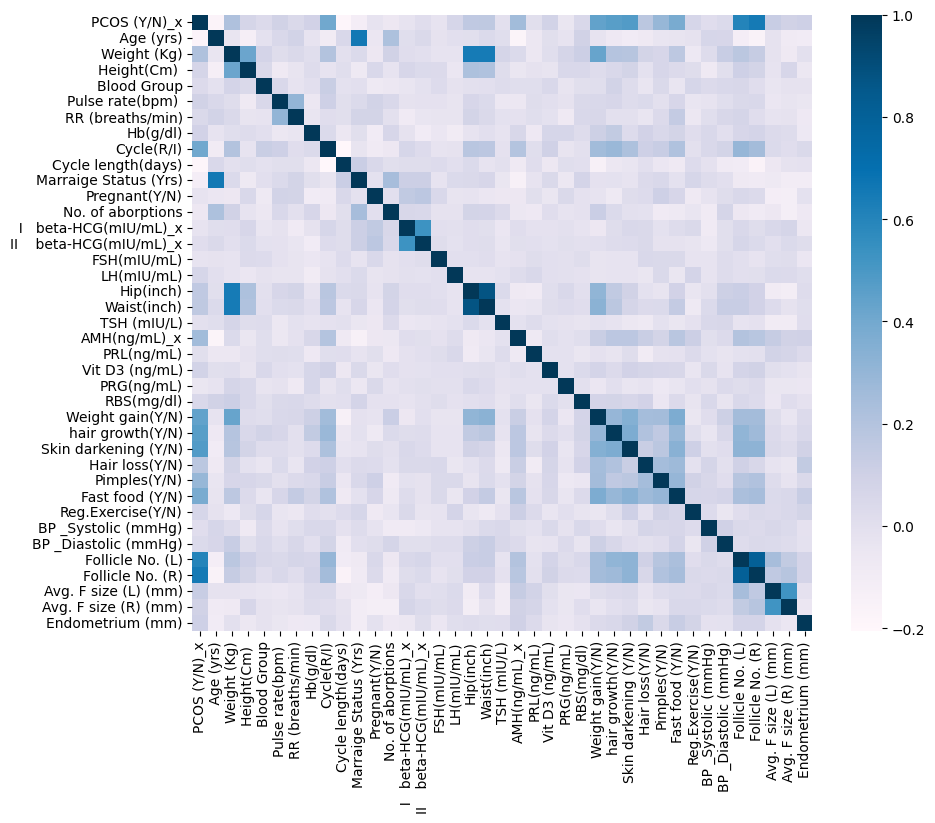

In [44]:
numeric_columns = data_clean.select_dtypes(include='number').columns
numeric_columns = numeric_columns.drop('Patient File No.', errors='ignore')
cor_matrix = data_clean[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, cmap='PuBu')
plt.show()

## Single Predictor

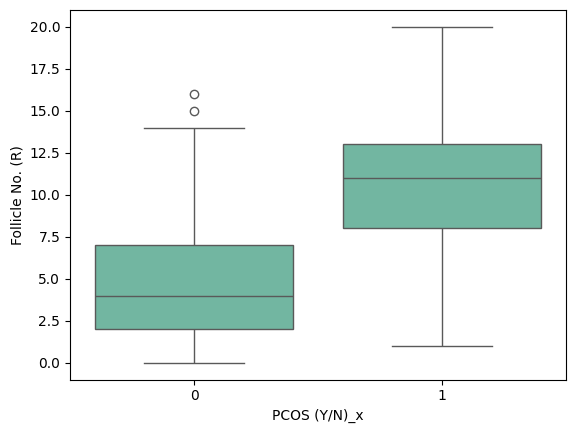

In [59]:
figure = sns.boxplot(data =data,y='Follicle No. (R)',x="PCOS (Y/N)_x",color = "#66c2a5")
plt.show()

## Two predictors

<Axes: xlabel='Follicle No. (R)', ylabel='Follicle No. (L)'>

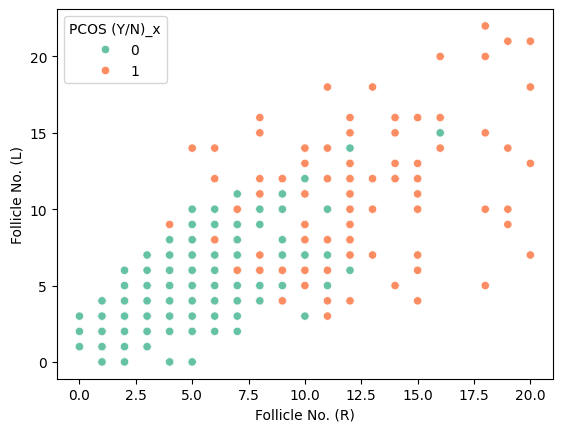

In [51]:
sns.scatterplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)_x",palette = 'Set2')

# Set up Models
## Split the data and do the k-fold validation

In [197]:
X = data_clean.drop(['PCOS (Y/N)_x','Patient File No.'],axis =1)
y = data_clean['PCOS (Y/N)_x']
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1022)

## Build the model

In [91]:
qda = QuadraticDiscriminantAnalysis()
en =  ElasticNet()
svm =  SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

qda_param_grid = {
    'reg_param': np.linspace(0, 0.5, 11),
    'store_covariance': [True, False]
}

en_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
svm_param_grid = {
    'C': [50,100,200,300],
    'gamma': ['scale', 'auto'],
    'kernel' : ["rbf"]
}

rf_param_grid = {"max_features": ['sqrt', 'log2'],
                "n_estimators":[100,200,300,400,500],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

xgb_param_grid = {
    'n_estimators': [200, 300,400,500],
    'max_depth': [3, 4, 5],
    'learning_rate': [ 0.1, 0.3,0.5,0.8]
}


## train the model

In [77]:
qda_search = GridSearchCV(qda, qda_param_grid, cv=skf, scoring='roc_auc')
qda_search.fit(X, y)
print(f"Best parameters for QDA: {qda_search.best_params_}")
print(f"Best score for QDA: {qda_search.best_score_}")

Best parameters for QDA: {'reg_param': 0.1, 'store_covariance': True}
Best score for QDA: 0.8763600782778864


In [76]:
en_search = GridSearchCV(en, en_param_grid, cv=skf, scoring='roc_auc')
en_search.fit(X, y)
print(f"Best parameters for Elastic Net Glm: {en_search.best_params_}")
print(f"Best score for Elastic Net Glm: {en_search.best_score_}")

Best parameters for Elastic Net Glm: {'alpha': 0.01, 'l1_ratio': 0.5}
Best score for Elastic Net Glm: 0.9475429441182867


In [80]:
svm_search = GridSearchCV(svm, svm_param_grid, cv=skf, scoring='roc_auc')
svm_search.fit(X, y)
print(f"Best parameters for SVM: {svm_search.best_params_}")
print(f"Best score for SVM: {svm_search.best_score_}")

Best parameters for SVM: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM: 0.8540796912372255


In [82]:
rf_search = GridSearchCV(rf, rf_param_grid, cv=skf, scoring='roc_auc')
rf_search.fit(X, y)
print(f"Best parameters for Random Forest: {rf_search.best_params_}")
print(f"Best score for Random Forest: {rf_search.best_score_}")

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}
Best score for Random Forest: 0.9607023265927376


In [92]:
xgb_search = GridSearchCV(xgb, xgb_param_grid, cv=skf, scoring='roc_auc')
xgb_search.fit(X, y)
print(f"Best parameters for XGBoost: {xgb_search.best_params_}")
print(f"Best score for XGBoost: {xgb_search.best_score_}")

Best parameters for XGBoost: {'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 400}
Best score for XGBoost: 0.9479854316155686


# Machine learning model selection
After analyzing each type of models, the following step is to select across different model. The criteria is the roc_auc of each best model on the overall training set.


In [94]:
best_score = {'qda':qda_search.best_score_,
              'en':en_search.best_score_,
              'svm':svm_search.best_score_,
              'rf':rf_search.best_score_,
              'xgb':xgb_search.best_score_}
best_score

{'qda': 0.8763600782778864,
 'en': 0.9475429441182867,
 'svm': 0.8540796912372255,
 'rf': 0.9607023265927376,
 'xgb': 0.9479854316155686}

By comparing the auc_roc, we find that random forest performs best, following by the XGboost.

Therefore, our final model is the random forest model
# Model Evaluation.

accuracy_final: 0.9197530864197531
Area Under Curve:  0.8990461049284579


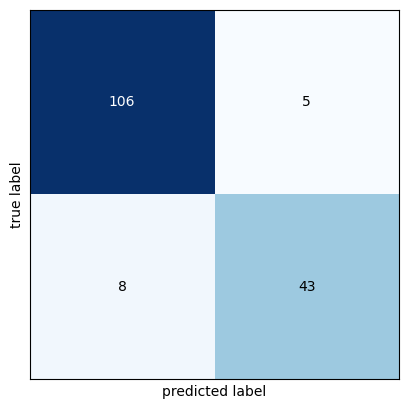

In [268]:
rf_b = RandomForestClassifier(**rf_search.best_params_)
rf_b.fit(X_train, y_train)

predictions=rf_b.predict(X_test)
accuracy_final = accuracy_score(y_test,predictions)

print(f'accuracy_final:',accuracy_final)
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(cm,hide_ticks = True)

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print("Area Under Curve: ", roc_auc)